In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

In [2]:
all_train_data = pd.read_csv('train.csv')
all_test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
all_train_data.dropna(inplace=True)
all_test_data.dropna(inplace=True)

dropped_columns = ['GPA']
y_train = all_train_data['Best Performance']
X_train = all_train_data.drop('Best Performance',axis=1)

#read x_test
for col in dropped_columns:
    X_train = X_train.drop(col,axis=1)
X_test = all_test_data

for col in dropped_columns:
    X_test = X_test.drop(col,axis=1)


In [3]:
X_train.isna().sum()

job_level                                0
job_duration_in_current_job_level        0
person_level                             0
job_duration_in_current_person_level     0
job_duration_in_current_branch           0
Employee_type                            0
gender                                   0
age                                      0
marital_status_maried(Y/N)               0
number_of_dependences                    0
Education_level                          0
year_graduated                           0
job_duration_from_training               0
branch_rotation                          0
job_rotation                             0
assign_of_otherposition                  0
annual leave                             0
sick_leaves                              0
Last_achievement_%                       0
Achievement_above_100%_during3quartal    0
dtype: int64

In [4]:
X_train

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,JG04,1.352775,PG03,1.352775,1.732051,RM_type_A,2,1985,Y,1,level_0,2011,4,2,3,2,3,0,46.37,0.0
1,JG04,1.292285,PG03,1.292285,1.039230,RM_type_A,2,1989,Y,0,level_1,2007,4,4,3,0,0,1,47.68,0.0
2,JG05,2.565151,PG06,2.308679,1.780449,RM_type_C,1,1970,Y,1,level_1,1989,28,10,9,6,2,1,40.73,0.0
3,JG05,2.828427,PG06,1.000000,1.385641,RM_type_A,2,1967,Y,2,level_1,1987,29,11,6,0,4,10,47.42,0.0
4,JG05,2.828427,PG06,2.828427,0.707107,RM_type_A,2,1965,Y,3,level_1,1985,30,9,8,2,3,0,47.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,JG04,1.256981,PG03,1.256981,1.224745,RM_type_A,2,1986,Y,1,level_5,2016,4,3,3,0,4,1,50.87,0.0
11149,JG04,1.385641,PG03,1.385641,1.802776,RM_type_B,1,1988,Y,2,level_5,2015,3,1,2,0,6,0,79.91,0.0
11150,JG04,1.256981,PG03,1.256981,1.385641,RM_type_B,2,1991,Y,0,level_5,2017,2,1,2,0,4,0,78.38,0.0
11151,JG04,1.118034,PG03,1.118034,0.000000,RM_type_A,1,1987,Y,1,level_5,2012,5,5,4,0,4,1,85.94,1.0


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11152 entries, 0 to 11152
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11152 non-null  object 
 1   job_duration_in_current_job_level      11152 non-null  float64
 2   person_level                           11152 non-null  object 
 3   job_duration_in_current_person_level   11152 non-null  float64
 4   job_duration_in_current_branch         11152 non-null  float64
 5   Employee_type                          11152 non-null  object 
 6   gender                                 11152 non-null  int64  
 7   age                                    11152 non-null  int64  
 8   marital_status_maried(Y/N)             11152 non-null  object 
 9   number_of_dependences                  11152 non-null  int64  
 10  Education_level                        11152 non-null  object 
 11  ye

In [6]:
# data contain values
cont_col=[col for col in X_train.columns if X_train[col].dtype!='O']
cont_col_test=[col for col in X_test.columns if X_test[col].dtype!='O']
cont_col

['job_duration_in_current_job_level',
 'job_duration_in_current_person_level',
 'job_duration_in_current_branch',
 'gender',
 'age',
 'number_of_dependences',
 'year_graduated',
 'job_duration_from_training',
 'branch_rotation',
 'job_rotation',
 'assign_of_otherposition',
 'annual leave',
 'sick_leaves',
 'Last_achievement_%',
 'Achievement_above_100%_during3quartal']

In [7]:
cont_col_test

['job_duration_in_current_job_level',
 'job_duration_in_current_person_level',
 'job_duration_in_current_branch',
 'gender',
 'age',
 'number_of_dependences',
 'year_graduated',
 'job_duration_from_training',
 'branch_rotation',
 'job_rotation',
 'assign_of_otherposition',
 'annual leave',
 'sick_leaves',
 'Last_achievement_%',
 'Achievement_above_100%_during3quartal']

In [8]:
# data contain category
cat_col=[col for col in X_train.columns if X_train[col].dtype=='O']
cat_col_test=[col for col in X_test.columns if X_test[col].dtype=='O']
cat_col_test

['job_level',
 'person_level',
 'Employee_type',
 'marital_status_maried(Y/N)',
 'Education_level']

In [9]:
categorical=X_train[cat_col]
categorical_test=X_test[cat_col_test]
categorical.head()

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level
0,JG04,PG03,RM_type_A,Y,level_0
1,JG04,PG03,RM_type_A,Y,level_1
2,JG05,PG06,RM_type_C,Y,level_1
3,JG05,PG06,RM_type_A,Y,level_1
4,JG05,PG06,RM_type_A,Y,level_1


In [10]:
#now extract how many categories in each cat_feature
for feature in categorical.columns:
    print('{} has total {} categories \n'.format(feature,len(categorical[feature].value_counts())))
print('---------------------------')
for feature in categorical_test.columns:
    print('{} has total {} categories \n'.format(feature,len(categorical_test[feature].value_counts())))

job_level has total 3 categories 

person_level has total 8 categories 

Employee_type has total 3 categories 

marital_status_maried(Y/N) has total 2 categories 

Education_level has total 6 categories 

---------------------------
job_level has total 4 categories 

person_level has total 7 categories 

Employee_type has total 3 categories 

marital_status_maried(Y/N) has total 2 categories 

Education_level has total 6 categories 



In [11]:
categorical['job_level'].value_counts()

JG04    10412
JG05      704
JG03       36
Name: job_level, dtype: int64

In [12]:
categorical_test['job_level'].value_counts()

JG04    5616
JG05     372
JG03      11
JG06       1
Name: job_level, dtype: int64

In [13]:
categorical['person_level'].value_counts()

PG03    9654
PG04     757
PG06     378
PG05     308
PG01      19
PG07      19
PG02      16
PG08       1
Name: person_level, dtype: int64

In [14]:
categorical_test['person_level'].value_counts()

PG03    5211
PG04     403
PG06     203
PG05     159
PG07      13
PG01       6
PG02       5
Name: person_level, dtype: int64

In [15]:
categorical['marital_status_maried(Y/N)'].value_counts()

Y    9501
N    1651
Name: marital_status_maried(Y/N), dtype: int64

In [16]:
categorical['Education_level'].value_counts()

level_4    9222
level_3    1742
level_1     140
level_5      43
level_2       4
level_0       1
Name: Education_level, dtype: int64

In [17]:
# categorical['marital_status_maried(Y/N)'].unique()

In [18]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for i in ['job_level', 'person_level', 'Employee_type', 'marital_status_maried(Y/N)','Education_level']:
    categorical[i]=encoder.fit_transform(categorical[i])
    categorical_test[i]=encoder.fit_transform(categorical_test[i])

C:\Users\farha\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\farha\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
categorical.info

<bound method DataFrame.info of        job_level  person_level  Employee_type  marital_status_maried(Y/N)  \
0              1             2              0                           1   
1              1             2              0                           1   
2              2             5              2                           1   
3              2             5              0                           1   
4              2             5              0                           1   
...          ...           ...            ...                         ...   
11148          1             2              0                           1   
11149          1             2              1                           1   
11150          1             2              1                           1   
11151          1             2              0                           1   
11152          1             3              1                           1   

       Education_level  
0                 

In [20]:
X_train[cont_col]

,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,1.352775,1.352775,1.732051,2,1985,1,2011,4,2,3,2,3,0,46.37,0.0
1,1.292285,1.292285,1.039230,2,1989,0,2007,4,4,3,0,0,1,47.68,0.0
2,2.565151,2.308679,1.780449,1,1970,1,1989,28,10,9,6,2,1,40.73,0.0
3,2.828427,1.000000,1.385641,2,1967,2,1987,29,11,6,0,4,10,47.42,0.0
4,2.828427,2.828427,0.707107,2,1965,3,1985,30,9,8,2,3,0,47.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,1.256981,1.256981,1.224745,2,1986,1,2016,4,3,3,0,4,1,50.87,0.0
11149,1.385641,1.385641,1.802776,1,1988,2,2015,3,1,2,0,6,0,79.91,0.0
11150,1.256981,1.256981,1.385641,2,1991,0,2017,2,1,2,0,4,0,78.38,0.0
11151,1.118034,1.118034,0.000000,1,1987,1,2012,5,5,4,0,4,1,85.94,1.0


In [21]:
def drop_column(df,col):
    df.drop(col,axis=1,inplace=True)

In [22]:
X_train=pd.concat([categorical,X_train[cont_col]],axis=1)
X_test=pd.concat([categorical_test,X_test[cont_col_test]],axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11152 entries, 0 to 11152
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11152 non-null  int32  
 1   person_level                           11152 non-null  int32  
 2   Employee_type                          11152 non-null  int32  
 3   marital_status_maried(Y/N)             11152 non-null  int32  
 4   Education_level                        11152 non-null  int32  
 5   job_duration_in_current_job_level      11152 non-null  float64
 6   job_duration_in_current_person_level   11152 non-null  float64
 7   job_duration_in_current_branch         11152 non-null  float64
 8   gender                                 11152 non-null  int64  
 9   age                                    11152 non-null  int64  
 10  number_of_dependences                  11152 non-null  int64  
 11  ye

In [23]:
X_test.head()

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,1,2,0,0,3,1.256981,1.256981,0.707107,1,1988,0,2009,6,4,2,6,3,7,84.02,0.0
1,1,2,1,0,4,1.224745,1.224745,1.256981,2,1991,0,2014,2,2,2,0,1,0,63.74,0.0
2,1,2,0,1,4,0.500000,0.500000,1.081665,2,1989,1,2011,4,2,2,0,2,1,88.19,1.0
3,1,2,0,1,4,1.256981,1.256981,1.802776,2,1990,1,2014,3,1,3,0,3,0,25.94,0.0
4,1,2,1,1,4,1.352775,1.352775,1.224745,1,1985,0,2007,5,3,2,0,3,0,82.32,0.0


In [24]:
tahun = 2020
X_train['age'] = tahun - X_train['age']
X_test['age'] = tahun - X_test['age']


In [25]:
X_train['age'].value_counts()

32    1558
33    1473
34    1348
31    1323
35     954
30     926
36     654
29     510
37     472
38     286
39     240
40     228
28     192
41     154
42     121
43      92
44      73
45      55
27      55
46      47
47      45
52      44
51      41
50      38
49      38
53      35
48      35
56      29
55      27
54      25
26      16
25       7
57       6
24       4
23       1
Name: age, dtype: int64

# Feature Correlation

C:\Users\farha\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.00292799 0.00490159 0.02168814 0.00978646 0.02547424 0.07111664
 0.07209262 0.07753718 0.01245344 0.07863164 0.0454504  0.07736787
 0.06296133 0.06060125 0.05649426 0.05132755 0.08374471 0.06143474
 0.09765278 0.02635516]


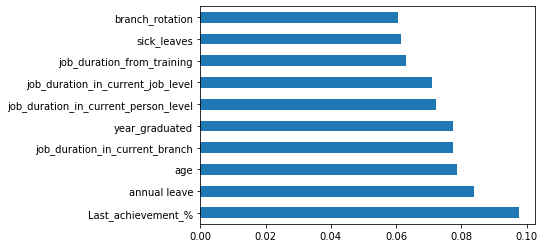

In [26]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [27]:
num_feats= len(X_train.columns)
print(num_feats)

20


In [28]:
# drop_column(X_train,'job_level')
# drop_column(X_train,'person_level')
# drop_column(X_train,'marital_status_maried(Y/N)')
# drop_column(X_train,'Employee_type')
# drop_column(X_train,'Achievement_above_100%_during3quartal')
# drop_column(X_train,'Education_level')

# drop_column(X_test,'job_level')
# drop_column(X_test,'person_level')
# drop_column(X_test,'marital_status_maried(Y/N)')
# drop_column(X_test,'Employee_type')
# drop_column(X_test,'Achievement_above_100%_during3quartal')
# drop_column(X_test,'Education_level')

In [29]:
# cat_columns = ['job_level', 'person_level', 'Employee_type', 'marital_status_maried(Y/N)', 'Education_level', 'Employee_type']
# for cat in cat_columns:
#     labelencoder = LabelEncoder()
#     X_train_[cat] = labelencoder.fit_transform(X_train_[cat].astype(str))
#     X_test_[cat] = labelencoder.transform(X_test_[cat].astype(str))       
    

In [30]:

#split x_train and x_val
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=38)


In [31]:
X_train_

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
9630,1,2,1,1,4,1.191638,1.191638,1.352775,1,32,2,2012,2,1,2,0,3,0,13.16,0.0
5422,1,2,0,1,4,1.292285,1.292285,0.707107,2,33,1,2010,6,3,4,3,0,0,97.15,3.0
2658,1,2,0,1,4,1.191638,1.191638,0.707107,1,32,0,2012,5,3,2,0,6,2,38.56,0.0
3330,1,2,1,1,4,1.256981,1.256981,1.224745,1,33,1,2009,6,3,4,0,2,5,95.58,3.0
5239,1,2,1,1,4,1.352775,1.352775,1.191638,2,38,1,2011,6,3,4,0,1,0,108.39,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,1,3,0,1,4,2.345208,1.581139,0.000000,2,43,3,2002,16,7,7,22,9,0,94.40,2.0
10978,2,5,0,1,4,2.828427,2.828427,0.412311,1,53,3,2003,30,14,9,0,2,0,64.91,0.0
5379,1,2,1,0,4,1.224745,1.224745,1.118034,2,31,0,2014,3,2,2,0,8,2,61.68,0.0
4413,1,2,0,1,4,1.322876,1.322876,1.118034,1,34,0,2010,6,3,5,2,7,1,110.56,3.0


# LGBM

In [32]:
class lgbm_target :
    def __init__(self, x_train, y_train, x_test, y_test) :
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
    def clean_param(self, param) :
        params = {'boosting_type':'gbdt', 'class_weight':None, 'colsample_bytree':1.0, 
                  'importance_type':'split', 'learning_rate':0.1,
                  'min_child_samples':2000, 'min_split_gain':0.0, 'n_estimators':10, 'objective':None,
                  'random_state':0, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
                  'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0}
        params['num_leaves'] = int(param['num_leaves'])
        params['min_child_weight'] = int(param['min_child_weight'])
        params['max_depth'] = int(param['max_depth'])
        params['learning_rate'] = 0.1
        params['min_data_in_bin'] = 1
        params['min_data'] = 1
        
        params['min_child_samples'] = int(param['min_child_samples'])
        params['bagging_fraction'] = param['bagging_fraction']
        params['lambda_l1'] = param['lambda_l1']
        params['lambda_l2'] = param['lambda_l2']

        return params
        
    def evaluate(self, min_child_weight, max_depth, num_leaves,
                min_child_samples, bagging_fraction, lambda_l1, lambda_l2):
        params = {'num_leaves':num_leaves, 
                  'min_child_weight':min_child_weight, 
                  'max_depth':max_depth,
                 'min_child_samples':min_child_samples,
                 'bagging_fraction' : bagging_fraction,
                 'lambda_l1' : lambda_l1,
                 'lambda_l2' : lambda_l2}
        
        params = self.clean_param(params)
        res=[]
        lgbm_model = lgb.LGBMClassifier(**params)
        lgbm_model.fit(self.x_train, self.y_train)
        y_pred = lgbm_model.predict_proba(self.x_test)
        predictions = y_pred[:,1]
        res.append(predictions)
        acc = roc_auc_score(self.y_test,predictions)
        print('######',acc)
        return acc


lt = lgbm_target(X_train_, y_train_, X_test_, y_test_)
lgbmBO = BayesianOptimization(lt.evaluate, {'min_child_weight': (0.01, 1),
                                              'max_depth': (7, 25),
                                              'num_leaves': (5, 50),
                                            'min_child_samples' :(10,50),
                                            'bagging_fraction' : (0.5,1),
                                            'lambda_l1' : (0,1),
                                            'lambda_l2' : (0,1)
                                           }, 
                             random_state=3)

lgbmBO.maximize(init_points=10, n_iter=55)

|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=45, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.7081478226181048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7081478226181048
[LightGBM] [Warning] bagging_fraction is set=0.7753989512872878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753989512872878
[LightGBM] [Warning] lambda_l2 is set=0.2909047389129443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2909047389129443
###### 0.5721569591139208
|  1        |  0.5722   |  0.7754   |  0.7081   |  0.2909   |  16.19    |  45.72    |  0.8973   |  10.65    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=28, will be overridden

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=48, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.10403680335492649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10403680335492649
[LightGBM] [Warning] bagging_fraction is set=0.8576971307109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8576971307109
[LightGBM] [Warning] lambda_l2 is set=0.8904419300576951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8904419300576951
###### 0.5860059620178346
|  12       |  0.586    |  0.8577   |  0.104    |  0.8904   |  10.34    |  48.78    |  0.4678   |  49.58    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=11, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.9840176267149954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9840176267149954
[LightGBM] [Warning] bagging_fraction is 

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=49, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.06768470885423561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06768470885423561
[LightGBM] [Warning] bagging_fraction is set=0.9868002924074316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9868002924074316
[LightGBM] [Warning] lambda_l2 is set=0.15732117120975142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15732117120975142
###### 0.5818886040654794
|  23       |  0.5819   |  0.9868   |  0.06768  |  0.1573   |  16.12    |  49.95    |  0.854    |  34.99    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=10, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.146859357256252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.146859357256252
[LightGBM] [Warning] bagging_fracti

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=10, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.9309415401094054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9309415401094054
[LightGBM] [Warning] bagging_fraction is set=0.9739856109520129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9739856109520129
[LightGBM] [Warning] lambda_l2 is set=0.1165969262923886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165969262923886
###### 0.5794440482615064
|  34       |  0.5794   |  0.974    |  0.9309   |  0.1166   |  8.655    |  10.09    |  0.9523   |  16.83    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=36, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.2622346642442609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2622346642442609
[LightGBM] [Warning] bagging_fraction

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=49, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.980814361689682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.980814361689682
[LightGBM] [Warning] bagging_fraction is set=0.9105691567044965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105691567044965
[LightGBM] [Warning] lambda_l2 is set=0.9220499984891676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9220499984891676
###### 0.5757009225708632
|  45       |  0.5757   |  0.9106   |  0.9808   |  0.922    |  16.67    |  49.95    |  0.9585   |  47.66    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=49, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.5524882342582551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5524882342582551
[LightGBM] [Warning] bagging_fraction i

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=11, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.007342406627368181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007342406627368181
[LightGBM] [Warning] bagging_fraction is set=0.9983747465306205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983747465306205
[LightGBM] [Warning] lambda_l2 is set=0.14423134413302874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14423134413302874
###### 0.5771593040886078
|  56       |  0.5772   |  0.9984   |  0.007342 |  0.1442   |  24.81    |  11.68    |  0.7763   |  29.73    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=10, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.39208339762351474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39208339762351474
[LightGBM] [Warning] bagging_

In [33]:
b=lgbmBO.max['params']
print(b)

{'bagging_fraction': 0.972511271297432, 'lambda_l1': 0.1455265956272246, 'lambda_l2': 0.9941950166431711, 'max_depth': 12.719655780524759, 'min_child_samples': 49.678069606304, 'min_child_weight': 0.12198257331441231, 'num_leaves': 41.5773640686795}


|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ch... | num_le... |

In [37]:
params = {'min_child_weight': b['min_child_weight'],
              'max_depth': int(round(b['max_depth'])),
              'num_leaves': int(round(b['num_leaves'])),
            'min_child_samples' :int(round(b['min_child_samples'])),
            'bagging_fraction' : b['bagging_fraction'],
            'lambda_l1' : b['lambda_l1'],
            'lambda_l2' : b['lambda_l2']
           }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)
model_lgb.predict_proba(X_test)[:,1]
sample_submission['Best Performance'] = model_lgb.predict_proba(X_test)[:,1]
# sample_submission.to_csv('submission.csv')

[LightGBM] [Warning] lambda_l1 is set=0.1455265956272246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1455265956272246
[LightGBM] [Warning] bagging_fraction is set=0.972511271297432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972511271297432
[LightGBM] [Warning] lambda_l2 is set=0.9941950166431711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9941950166431711


In [38]:
'''ADVERSARIAL VALIDATION'''
y_label_adv = np.zeros((X_train.shape[0]+ X_test.shape[0]))
y_label_adv[:X_train.shape[0]] = 1
adversarial_data = pd.concat((X_train,X_test))
# model_lgb = lgb.LGBMClassifier()
X_train_, X_test_, y_train_, y_test_ = train_test_split(adversarial_data, y_label_adv, test_size=0.33, random_state=38)

model_lgb.fit(X_train_,y_train_)
y_pred  = model_lgb.predict(X_test_)
roc_auc_score(y_pred,y_test_)

[LightGBM] [Warning] lambda_l1 is set=0.1455265956272246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1455265956272246
[LightGBM] [Warning] bagging_fraction is set=0.972511271297432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972511271297432
[LightGBM] [Warning] lambda_l2 is set=0.9941950166431711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9941950166431711


0.4773250320419867

In [201]:
'''0.55 acc'''
params = {'min_child_weight': 0.6715,
              'max_depth': 12,
              'num_leaves': 20,
            'min_child_samples' :24,
            'bagging_fraction' : 0.8538,
            'lambda_l1' : 0.7467,
            'lambda_l2' : 0.6911
           }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)
model_lgb.predict_proba(X_test)[:,1]
sample_submission['Best Performance'] = model_lgb.predict_proba(X_test)[:,1]
# sample_submission.to_csv('submission.csv')

[LightGBM] [Warning] lambda_l1 is set=0.7467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7467
[LightGBM] [Warning] bagging_fraction is set=0.8538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8538
[LightGBM] [Warning] lambda_l2 is set=0.6911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6911


In [80]:
'''0.55 acc-modified'''
params = {'min_child_weight': 0.5,
              'max_depth': 12,
              'num_leaves': 20,
            'min_child_samples' :24,
            'bagging_fraction' : 0.7,
            'lambda_l1' : 0.746,
            'lambda_l2' : 0.6
           }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)
model_lgb.predict_proba(X_test)[:,1]
sample_submission['Best Performance'] = model_lgb.predict_proba(X_test)[:,1]
# sample_submission.to_csv('submission.csv')

[LightGBM] [Warning] lambda_l1 is set=0.746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.746
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6


In [82]:
y_label_adv.shape

(17152,)

In [83]:
sample_submission

,index,Best Performance
0,0,0.122179
1,1,0.118160
2,2,0.414449
3,3,0.100791
4,4,0.115633
...,...,...
5995,5995,0.111780
5996,5996,0.062304
5997,5997,0.240500
5998,5998,0.169716


In [84]:
sample_submission.to_csv('submission_54.csv', index=False)

# CatBoost

In [39]:

from catboost import Pool, CatBoostClassifier, cv
cate_features_index = np.where(X_train.dtypes != float)[0] 
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=38)


In [40]:
model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=42)

In [41]:
model.fit(X_train_, y_train_, cat_features=cate_features_index,eval_set=(X_test_, y_test_))


0:	test: 0.4882880	best: 0.4882880 (0)	total: 104ms	remaining: 2m 35s
1:	test: 0.5009043	best: 0.5009043 (1)	total: 135ms	remaining: 1m 41s
2:	test: 0.5083142	best: 0.5083142 (2)	total: 163ms	remaining: 1m 21s
3:	test: 0.5152977	best: 0.5152977 (3)	total: 175ms	remaining: 1m 5s
4:	test: 0.5479852	best: 0.5479852 (4)	total: 219ms	remaining: 1m 5s
5:	test: 0.5470922	best: 0.5479852 (4)	total: 233ms	remaining: 58.1s
6:	test: 0.5485908	best: 0.5485908 (6)	total: 257ms	remaining: 54.8s
7:	test: 0.5439080	best: 0.5485908 (6)	total: 302ms	remaining: 56.4s
8:	test: 0.5444132	best: 0.5485908 (6)	total: 348ms	remaining: 57.6s
9:	test: 0.5444132	best: 0.5485908 (6)	total: 358ms	remaining: 53.3s
10:	test: 0.5439956	best: 0.5485908 (6)	total: 376ms	remaining: 50.9s
11:	test: 0.5456371	best: 0.5485908 (6)	total: 412ms	remaining: 51.1s
12:	test: 0.5431339	best: 0.5485908 (6)	total: 456ms	remaining: 52.1s
13:	test: 0.5431339	best: 0.5485908 (6)	total: 468ms	remaining: 49.7s
14:	test: 0.5430809	best: 0

121:	test: 0.5454018	best: 0.5485908 (6)	total: 3.44s	remaining: 38.9s
122:	test: 0.5451769	best: 0.5485908 (6)	total: 3.49s	remaining: 39.1s
123:	test: 0.5416466	best: 0.5485908 (6)	total: 3.55s	remaining: 39.4s
124:	test: 0.5422055	best: 0.5485908 (6)	total: 3.56s	remaining: 39.2s
125:	test: 0.5423437	best: 0.5485908 (6)	total: 3.58s	remaining: 39.1s
126:	test: 0.5420369	best: 0.5485908 (6)	total: 3.62s	remaining: 39.1s
127:	test: 0.5420369	best: 0.5485908 (6)	total: 3.63s	remaining: 39s
128:	test: 0.5410363	best: 0.5485908 (6)	total: 3.67s	remaining: 39s
129:	test: 0.5410363	best: 0.5485908 (6)	total: 3.68s	remaining: 38.8s
130:	test: 0.5410363	best: 0.5485908 (6)	total: 3.69s	remaining: 38.6s
131:	test: 0.5410363	best: 0.5485908 (6)	total: 3.71s	remaining: 38.4s
132:	test: 0.5409270	best: 0.5485908 (6)	total: 3.72s	remaining: 38.3s
133:	test: 0.5425428	best: 0.5485908 (6)	total: 3.79s	remaining: 38.6s
134:	test: 0.5425316	best: 0.5485908 (6)	total: 3.81s	remaining: 38.6s
135:	test:

238:	test: 0.5599390	best: 0.5644033 (205)	total: 6.94s	remaining: 36.6s
239:	test: 0.5598346	best: 0.5644033 (205)	total: 6.99s	remaining: 36.7s
240:	test: 0.5599647	best: 0.5644033 (205)	total: 7.01s	remaining: 36.6s
241:	test: 0.5582477	best: 0.5644033 (205)	total: 7.06s	remaining: 36.7s
242:	test: 0.5582477	best: 0.5644033 (205)	total: 7.07s	remaining: 36.6s
243:	test: 0.5597222	best: 0.5644033 (205)	total: 7.12s	remaining: 36.7s
244:	test: 0.5614070	best: 0.5644033 (205)	total: 7.17s	remaining: 36.7s
245:	test: 0.5614070	best: 0.5644033 (205)	total: 7.19s	remaining: 36.6s
246:	test: 0.5625490	best: 0.5644033 (205)	total: 7.24s	remaining: 36.7s
247:	test: 0.5624285	best: 0.5644033 (205)	total: 7.29s	remaining: 36.8s
248:	test: 0.5624285	best: 0.5644033 (205)	total: 7.3s	remaining: 36.7s
249:	test: 0.5624285	best: 0.5644033 (205)	total: 7.31s	remaining: 36.5s
250:	test: 0.5624735	best: 0.5644033 (205)	total: 7.33s	remaining: 36.5s
251:	test: 0.5620069	best: 0.5644033 (205)	total: 7.

352:	test: 0.5668912	best: 0.5672124 (344)	total: 11.7s	remaining: 38.1s
353:	test: 0.5668912	best: 0.5672124 (344)	total: 11.7s	remaining: 38s
354:	test: 0.5668591	best: 0.5672124 (344)	total: 11.8s	remaining: 38.1s
355:	test: 0.5670085	best: 0.5672124 (344)	total: 11.8s	remaining: 38s
356:	test: 0.5671964	best: 0.5672124 (344)	total: 11.9s	remaining: 38s
357:	test: 0.5671466	best: 0.5672124 (344)	total: 11.9s	remaining: 38.1s
358:	test: 0.5672333	best: 0.5672333 (358)	total: 12s	remaining: 38.1s
359:	test: 0.5672735	best: 0.5672735 (359)	total: 12.1s	remaining: 38.2s
360:	test: 0.5671498	best: 0.5672735 (359)	total: 12.1s	remaining: 38.2s
361:	test: 0.5671498	best: 0.5672735 (359)	total: 12.1s	remaining: 38.1s
362:	test: 0.5669522	best: 0.5672735 (359)	total: 12.2s	remaining: 38.2s
363:	test: 0.5666920	best: 0.5672735 (359)	total: 12.2s	remaining: 38.2s
364:	test: 0.5670647	best: 0.5672735 (359)	total: 12.3s	remaining: 38.2s
365:	test: 0.5666439	best: 0.5672735 (359)	total: 12.3s	rem

468:	test: 0.5696554	best: 0.5703380 (448)	total: 17.2s	remaining: 37.8s
469:	test: 0.5696698	best: 0.5703380 (448)	total: 17.3s	remaining: 37.8s
470:	test: 0.5702047	best: 0.5703380 (448)	total: 17.3s	remaining: 37.8s
471:	test: 0.5702561	best: 0.5703380 (448)	total: 17.4s	remaining: 37.8s
472:	test: 0.5702609	best: 0.5703380 (448)	total: 17.4s	remaining: 37.8s
473:	test: 0.5701388	best: 0.5703380 (448)	total: 17.5s	remaining: 37.8s
474:	test: 0.5703492	best: 0.5703492 (474)	total: 17.5s	remaining: 37.8s
475:	test: 0.5701806	best: 0.5703492 (474)	total: 17.6s	remaining: 37.8s
476:	test: 0.5700826	best: 0.5703492 (474)	total: 17.6s	remaining: 37.8s
477:	test: 0.5698032	best: 0.5703492 (474)	total: 17.7s	remaining: 37.8s
478:	test: 0.5695783	best: 0.5703492 (474)	total: 17.7s	remaining: 37.8s
479:	test: 0.5695879	best: 0.5703492 (474)	total: 17.8s	remaining: 37.8s
480:	test: 0.5695044	best: 0.5703492 (474)	total: 17.8s	remaining: 37.7s
481:	test: 0.5695140	best: 0.5703492 (474)	total: 1

583:	test: 0.5705982	best: 0.5713306 (577)	total: 22.4s	remaining: 35.1s
584:	test: 0.5709403	best: 0.5713306 (577)	total: 22.5s	remaining: 35.1s
585:	test: 0.5711555	best: 0.5713306 (577)	total: 22.5s	remaining: 35.1s
586:	test: 0.5712182	best: 0.5713306 (577)	total: 22.5s	remaining: 35.1s
587:	test: 0.5713852	best: 0.5713852 (587)	total: 22.6s	remaining: 35s
588:	test: 0.5715458	best: 0.5715458 (588)	total: 22.6s	remaining: 35s
589:	test: 0.5716823	best: 0.5716823 (589)	total: 22.7s	remaining: 35s
590:	test: 0.5716326	best: 0.5716823 (589)	total: 22.8s	remaining: 35s
591:	test: 0.5717530	best: 0.5717530 (591)	total: 22.8s	remaining: 35s
592:	test: 0.5713001	best: 0.5717530 (591)	total: 22.9s	remaining: 35s
593:	test: 0.5712278	best: 0.5717530 (591)	total: 22.9s	remaining: 34.9s
594:	test: 0.5718654	best: 0.5718654 (594)	total: 23s	remaining: 34.9s
595:	test: 0.5718895	best: 0.5718895 (595)	total: 23s	remaining: 34.9s
596:	test: 0.5718831	best: 0.5718895 (595)	total: 23s	remaining: 34

698:	test: 0.5694000	best: 0.5731327 (606)	total: 27.8s	remaining: 31.9s
699:	test: 0.5693872	best: 0.5731327 (606)	total: 27.8s	remaining: 31.8s
700:	test: 0.5693663	best: 0.5731327 (606)	total: 27.9s	remaining: 31.8s
701:	test: 0.5695767	best: 0.5731327 (606)	total: 27.9s	remaining: 31.7s
702:	test: 0.5696441	best: 0.5731327 (606)	total: 28s	remaining: 31.7s
703:	test: 0.5695879	best: 0.5731327 (606)	total: 28s	remaining: 31.7s
704:	test: 0.5695735	best: 0.5731327 (606)	total: 28.1s	remaining: 31.7s
705:	test: 0.5695285	best: 0.5731327 (606)	total: 28.1s	remaining: 31.6s
706:	test: 0.5696682	best: 0.5731327 (606)	total: 28.2s	remaining: 31.6s
707:	test: 0.5697999	best: 0.5731327 (606)	total: 28.2s	remaining: 31.6s
708:	test: 0.5695960	best: 0.5731327 (606)	total: 28.3s	remaining: 31.5s
709:	test: 0.5695976	best: 0.5731327 (606)	total: 28.3s	remaining: 31.5s
710:	test: 0.5696313	best: 0.5731327 (606)	total: 28.4s	remaining: 31.5s
711:	test: 0.5694819	best: 0.5731327 (606)	total: 28.4s

813:	test: 0.5675594	best: 0.5731327 (606)	total: 33.3s	remaining: 28.1s
814:	test: 0.5676975	best: 0.5731327 (606)	total: 33.4s	remaining: 28s
815:	test: 0.5677168	best: 0.5731327 (606)	total: 33.4s	remaining: 28s
816:	test: 0.5677906	best: 0.5731327 (606)	total: 33.5s	remaining: 28s
817:	test: 0.5674212	best: 0.5731327 (606)	total: 33.5s	remaining: 27.9s
818:	test: 0.5674180	best: 0.5731327 (606)	total: 33.6s	remaining: 27.9s
819:	test: 0.5672189	best: 0.5731327 (606)	total: 33.6s	remaining: 27.9s
820:	test: 0.5673056	best: 0.5731327 (606)	total: 33.7s	remaining: 27.8s
821:	test: 0.5672895	best: 0.5731327 (606)	total: 33.7s	remaining: 27.8s
822:	test: 0.5674373	best: 0.5731327 (606)	total: 33.8s	remaining: 27.8s
823:	test: 0.5674373	best: 0.5731327 (606)	total: 33.8s	remaining: 27.7s
824:	test: 0.5673875	best: 0.5731327 (606)	total: 33.8s	remaining: 27.7s
825:	test: 0.5680187	best: 0.5731327 (606)	total: 33.9s	remaining: 27.6s
826:	test: 0.5679191	best: 0.5731327 (606)	total: 33.9s	r

929:	test: 0.5662230	best: 0.5731327 (606)	total: 38.9s	remaining: 23.8s
930:	test: 0.5661315	best: 0.5731327 (606)	total: 38.9s	remaining: 23.8s
931:	test: 0.5664800	best: 0.5731327 (606)	total: 39s	remaining: 23.8s
932:	test: 0.5666712	best: 0.5731327 (606)	total: 39s	remaining: 23.7s
933:	test: 0.5667386	best: 0.5731327 (606)	total: 39.1s	remaining: 23.7s
934:	test: 0.5666117	best: 0.5731327 (606)	total: 39.1s	remaining: 23.7s
935:	test: 0.5666567	best: 0.5731327 (606)	total: 39.2s	remaining: 23.6s
936:	test: 0.5664865	best: 0.5731327 (606)	total: 39.2s	remaining: 23.6s
937:	test: 0.5663772	best: 0.5731327 (606)	total: 39.3s	remaining: 23.5s
938:	test: 0.5663467	best: 0.5731327 (606)	total: 39.3s	remaining: 23.5s
939:	test: 0.5659548	best: 0.5731327 (606)	total: 39.4s	remaining: 23.5s
940:	test: 0.5658713	best: 0.5731327 (606)	total: 39.4s	remaining: 23.4s
941:	test: 0.5659147	best: 0.5731327 (606)	total: 39.5s	remaining: 23.4s
942:	test: 0.5659147	best: 0.5731327 (606)	total: 39.5s

1044:	test: 0.5631087	best: 0.5731327 (606)	total: 44.8s	remaining: 19.5s
1045:	test: 0.5631200	best: 0.5731327 (606)	total: 44.8s	remaining: 19.4s
1046:	test: 0.5632854	best: 0.5731327 (606)	total: 44.9s	remaining: 19.4s
1047:	test: 0.5637416	best: 0.5731327 (606)	total: 44.9s	remaining: 19.4s
1048:	test: 0.5640403	best: 0.5731327 (606)	total: 45s	remaining: 19.3s
1049:	test: 0.5640130	best: 0.5731327 (606)	total: 45s	remaining: 19.3s
1050:	test: 0.5637399	best: 0.5731327 (606)	total: 45.1s	remaining: 19.2s
1051:	test: 0.5635360	best: 0.5731327 (606)	total: 45.1s	remaining: 19.2s
1052:	test: 0.5633914	best: 0.5731327 (606)	total: 45.2s	remaining: 19.2s
1053:	test: 0.5633994	best: 0.5731327 (606)	total: 45.2s	remaining: 19.1s
1054:	test: 0.5636484	best: 0.5731327 (606)	total: 45.3s	remaining: 19.1s
1055:	test: 0.5635890	best: 0.5731327 (606)	total: 45.3s	remaining: 19.1s
1056:	test: 0.5637576	best: 0.5731327 (606)	total: 45.4s	remaining: 19s
1057:	test: 0.5638668	best: 0.5731327 (606)	

1157:	test: 0.5607011	best: 0.5731327 (606)	total: 50.5s	remaining: 14.9s
1158:	test: 0.5609292	best: 0.5731327 (606)	total: 50.6s	remaining: 14.9s
1159:	test: 0.5609934	best: 0.5731327 (606)	total: 50.6s	remaining: 14.8s
1160:	test: 0.5610866	best: 0.5731327 (606)	total: 50.7s	remaining: 14.8s
1161:	test: 0.5610930	best: 0.5731327 (606)	total: 50.7s	remaining: 14.8s
1162:	test: 0.5610689	best: 0.5731327 (606)	total: 50.8s	remaining: 14.7s
1163:	test: 0.5610946	best: 0.5731327 (606)	total: 50.8s	remaining: 14.7s
1164:	test: 0.5610882	best: 0.5731327 (606)	total: 50.9s	remaining: 14.6s
1165:	test: 0.5611814	best: 0.5731327 (606)	total: 50.9s	remaining: 14.6s
1166:	test: 0.5612215	best: 0.5731327 (606)	total: 51s	remaining: 14.5s
1167:	test: 0.5613452	best: 0.5731327 (606)	total: 51s	remaining: 14.5s
1168:	test: 0.5613580	best: 0.5731327 (606)	total: 51.1s	remaining: 14.5s
1169:	test: 0.5610352	best: 0.5731327 (606)	total: 51.1s	remaining: 14.4s
1170:	test: 0.5608810	best: 0.5731327 (606

1272:	test: 0.5601775	best: 0.5731327 (606)	total: 56.4s	remaining: 10.1s
1273:	test: 0.5601341	best: 0.5731327 (606)	total: 56.5s	remaining: 10s
1274:	test: 0.5600057	best: 0.5731327 (606)	total: 56.5s	remaining: 9.97s
1275:	test: 0.5601149	best: 0.5731327 (606)	total: 56.6s	remaining: 9.93s
1276:	test: 0.5599157	best: 0.5731327 (606)	total: 56.6s	remaining: 9.89s
1277:	test: 0.5600924	best: 0.5731327 (606)	total: 56.7s	remaining: 9.84s
1278:	test: 0.5601663	best: 0.5731327 (606)	total: 56.7s	remaining: 9.8s
1279:	test: 0.5599639	best: 0.5731327 (606)	total: 56.8s	remaining: 9.76s
1280:	test: 0.5598675	best: 0.5731327 (606)	total: 56.8s	remaining: 9.72s
1281:	test: 0.5599382	best: 0.5731327 (606)	total: 56.9s	remaining: 9.67s
1282:	test: 0.5602948	best: 0.5731327 (606)	total: 56.9s	remaining: 9.63s
1283:	test: 0.5603622	best: 0.5731327 (606)	total: 57s	remaining: 9.59s
1284:	test: 0.5602867	best: 0.5731327 (606)	total: 57s	remaining: 9.54s
1285:	test: 0.5602482	best: 0.5731327 (606)	t

1384:	test: 0.5602755	best: 0.5731327 (606)	total: 1m 2s	remaining: 5.16s
1385:	test: 0.5602402	best: 0.5731327 (606)	total: 1m 2s	remaining: 5.12s
1386:	test: 0.5601839	best: 0.5731327 (606)	total: 1m 2s	remaining: 5.08s
1387:	test: 0.5602032	best: 0.5731327 (606)	total: 1m 2s	remaining: 5.03s
1388:	test: 0.5602048	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.99s
1389:	test: 0.5602610	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.94s
1390:	test: 0.5603301	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.9s
1391:	test: 0.5603397	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.85s
1392:	test: 0.5601727	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.81s
1393:	test: 0.5601727	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.76s
1394:	test: 0.5602193	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.72s
1395:	test: 0.5601871	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.68s
1396:	test: 0.5601759	best: 0.5731327 (606)	total: 1m 2s	remaining: 4.63s
1397:	test: 0.5601647	best: 0.5731327 (

1495:	test: 0.5594756	best: 0.5731327 (606)	total: 1m 7s	remaining: 182ms
1496:	test: 0.5596362	best: 0.5731327 (606)	total: 1m 7s	remaining: 136ms
1497:	test: 0.5595784	best: 0.5731327 (606)	total: 1m 8s	remaining: 90.8ms
1498:	test: 0.5594596	best: 0.5731327 (606)	total: 1m 8s	remaining: 45.4ms
1499:	test: 0.5594387	best: 0.5731327 (606)	total: 1m 8s	remaining: 0us

bestTest = 0.5731326934
bestIteration = 606

Shrink model to first 607 iterations.


In [42]:
pred = model.predict_proba(X_test)
preds= pred[:,1]

In [43]:
preds

array([0.13229838, 0.16714023, 0.20289716, ..., 0.15288645, 0.12260639,
       0.12919172])

In [249]:
#generating submission csv
submission = pd.DataFrame(preds)
#save the file to your directory
submission.to_csv('test-catboost2.csv',index_label='index',header=['value'])

# XGBoost

In [44]:
import xgboost as xgb

In [45]:
from sklearn.model_selection import cross_val_score
# fit model to training data
model = xgb.XGBRFClassifier(n_estimators=1000, random_state=1245)
# cross validation score
score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print("XGB ROC-AUC Mean Score: ", np.mean(score))

XGB ROC-AUC Mean Score:  0.5708434436587565


In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)

def hyp_xgb(max_depth, subsample, colsample_bytree,min_child_weight, gamma, learning_rate):
    params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread':-1,
#     'booster':'dart'
    'booster':'gbtree'
     }
    
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    params['learning_rate'] = learning_rate
    scores = xgb.cv(params, dtrain, num_boost_round=500,verbose_eval=False, 
                    early_stopping_rounds=10, nfold=5)
    return scores['test-auc-mean'].iloc[-1]

In [48]:
pds ={
  'min_child_weight':(3, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 15),
  'learning_rate': (0.01, 0.5)
}

In [49]:
optimizer = BayesianOptimization(hyp_xgb, pds, random_state=1)
optimizer.maximize(init_points=5, n_iter=55)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.5755   |  0.4753   |  7.203    |  0.01006  |  5.93     |  5.495    |  0.5462   |
|  2        |  0.5709   |  0.2676   |  3.456    |  0.2044   |  9.005    |  10.13    |  0.8426   |
|  3        |  0.5722   |  0.284    |  8.781    |  0.02342  |  10.72    |  10.09    |  0.7793   |
|  4        |  0.5653   |  0.2263   |  1.981    |  0.4024   |  14.59    |  8.328    |  0.8462   |
|  5        |  0.5716   |  0.8888   |  8.946    |  0.05167  |  2.508    |  5.887    |  0.9391   |
|  6        |  0.573    |  0.2841   |  9.897    |  0.4061   |  2.665    |  19.83    |  0.5422   |
|  7        |  0.5692   |  0.135    |  0.7945   |  0.2452   |  2.345    |  3.517    |  0.5157   |
|  8        |  0.5644   |  0.7889   |  9.918    |  0.06384  |  2.428    |  4.469    |  0.7597   |
|  9        |  0.583

|  51       |  0.5737   |  0.3693   |  2.086    |  0.04665  |  13.07    |  11.26    |  0.5014   |
|  52       |  0.5786   |  0.9109   |  3.977    |  0.02836  |  3.601    |  14.18    |  0.5455   |
|  53       |  0.5771   |  0.8025   |  0.2986   |  0.04511  |  2.189    |  19.88    |  0.714    |
|  54       |  0.5737   |  0.1063   |  2.836    |  0.1253   |  2.287    |  16.91    |  0.5996   |
|  55       |  0.5803   |  0.9936   |  9.275    |  0.04859  |  10.65    |  6.361    |  0.9089   |
|  56       |  0.5786   |  0.8873   |  1.619    |  0.09233  |  2.296    |  18.11    |  0.5112   |
|  57       |  0.585    |  0.9786   |  0.1396   |  0.211    |  4.287    |  3.818    |  0.9724   |
|  58       |  0.5773   |  0.8999   |  9.129    |  0.2792   |  8.245    |  13.45    |  0.9862   |
|  59       |  0.5777   |  0.221    |  5.575    |  0.05699  |  8.516    |  19.87    |  0.5899   |
|  60       |  0.5799   |  0.9446   |  5.507    |  0.07185  |  5.601    |  11.51    |  0.9965   |


In [50]:
a = optimizer.max['params']

In [54]:
int(a['min_child_weight'])

12

In [55]:
params = {
    'colsample_bytree': a['colsample_bytree'],
 'gamma': a['gamma'],
 'learning_rate': a['learning_rate'],
 'max_depth': int(round(a['max_depth'])),
 'min_child_weight': int(round(a['min_child_weight'])),
 'subsample': a['subsample'],
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}

In [56]:
xgbr =  xgb.XGBClassifier(**params, random_state=1245, nthread=-1)
score = cross_val_score(xgbr, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print("XGB ROC-AUC Mean Score: ", np.mean(score))

XGB ROC-AUC Mean Score:  0.563759408197716


In [57]:

xgbr.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9846913473129812,
              eval_metric='auc', gamma=0.7352558343800741,
              learning_rate=0.1352590364431485, max_delta_step=0, max_depth=13,
              min_child_weight=12, missing=None, n_estimators=100, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=1245,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5079224784034219, verbosity=1)

In [58]:
'''ADVERSARIAL VALIDATION'''
y_label_adv = np.zeros((X_train.shape[0]+ X_test.shape[0]))
y_label_adv[:X_train.shape[0]] = 1
adversarial_data = pd.concat((X_train,X_test))
# model_lgb = lgb.LGBMClassifier()
X_train_, X_test_, y_train_, y_test_ = train_test_split(adversarial_data, y_label_adv, test_size=0.33, random_state=38)

xgbr.fit(X_train_,y_train_)
y_pred  = model_lgb.predict(X_test_)
roc_auc_score(y_pred,y_test_)

0.4773250320419867

In [123]:
# Predict the probability using predict_proba
y_pred = xgbr.predict_proba(X_test)[:,1]

In [127]:
y_pred

array([0.10417285, 0.15825823, 0.37411457, ..., 0.24042304, 0.12350464,
       0.13302727], dtype=float32)

In [128]:
#generating submission csv
submission = pd.DataFrame(y_pred)
#save the file to your directory
submission.to_csv('test-xgboost.csv',index_label='index',header=['value'])